# Epoxy-resin polymer thermoset material

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the epoxy resin application. Small variation in the results will occur due to the stochastic nature of the training procedure. Some KAS-GP are also displayed. These are loaded from file, and not directly computed here.

### Reference

Wouter Edeling, Maxime Vassaux, Yiming Yang, Shunzhou Wan, Serge Guillas, Peter Coveney, *Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [1]:
#!pip install easysurrogate==0.24.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [3]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [4]:
%matplotlib inline
# save figures at 300 dpi
plt.rcParams['savefig.dpi'] = 300

### Load prior ranges

The JSON file below contains all default values and boundaries used for specifying the Uniform input parameter distributions. 

In [5]:
# Load the EasyVVUQ params dict
priors = json.load(open('./epoxy.params.json', 'r'))
priors

{'p11': {'type': 'float', 'default': 0.01},
 'p12': {'type': 'float', 'default': 3.0},
 'p21': {'type': 'float', 'default': 0.015},
 'p22': {'type': 'float', 'default': 2.5},
 'p31': {'type': 'float', 'default': 0.03},
 'p32': {'type': 'float', 'default': 2.42},
 'p41': {'type': 'float', 'default': 0.03},
 'p42': {'type': 'float', 'default': 2.5},
 'p51': {'type': 'float', 'default': 0.066},
 'p52': {'type': 'float', 'default': 3.5},
 'p61': {'type': 'float', 'default': 0.07},
 'p62': {'type': 'float', 'default': 3.55},
 'p71': {'type': 'float', 'default': 0.14},
 'p72': {'type': 'float', 'default': 2.9},
 'p81': {'type': 'float', 'default': 0.17},
 'p82': {'type': 'float', 'default': 3.12},
 'p91': {'type': 'float', 'default': 0.17},
 'p92': {'type': 'float', 'default': 3.3},
 'b11': {'type': 'float', 'default': 268.0},
 'b12': {'type': 'float', 'default': 1.5290000000000001},
 'b21': {'type': 'float', 'default': 317.0},
 'b22': {'type': 'float', 'default': 1.51},
 'b31': {'type': 'fl

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [6]:
# input parameters
params = pd.read_csv('./data_epoxy/epoxy_inputs.csv')
param_names = params.keys()
params = params.values

# number of samples
n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

# scale inputs within [-1, 1]
p_max = np.array([priors[name]['default'] * 1.15 for name in param_names])
p_min = np.array([priors[name]['default'] * 0.85 for name in param_names])
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

### Load output samples

Load the corresponding Monte Carlo outputs. We used `E11`, the 11 component of the elasticity tensor (equal to the Young's modulus `E` in this isotropic case), and the Poisson ratio.

In [40]:
# Output QoI
QoI = 'E11'   # E11=E22_E33=E due to isotropy of the material
#QoI = 'poisson'

output = pd.read_csv('./data_epoxy/epoxy_%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [43]:
average_over_replicas = False

if not average_over_replicas:
    samples = output[:, 0].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Print uncertainty amplification factor

In [44]:
# coefficient of variation of the input, assuming uniform inputs at +/- 15% at the default value
# for all inputs except the temperature, which is at +/- 7.5 %
CV_in = 1 / (D * np.sqrt(3)) * ((D-1) * 0.15 + 0.075)

# coefficient of variation of the output
mean_out = np.mean(samples)
std_out = np.std(samples)
CV_out = std_out / mean_out

# print CV ratio
print('CVR = %.1f' % (np.abs(CV_out) / np.abs(CV_in)))

CVR = 1.9


### Select $d$

This is the dimension of the active subspace.

In [9]:
d = 1

###  Set hyperparameters

In [10]:
# number of neurons per hidden layer 
n_hidden_neurons = 10
# number of hidden layer + output layer
n_layers = 4
# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [11]:
# test fraction
test_frac = 0.1
# indices of the test set
test_idx = int((1 - test_frac) * n_samples)
# training set
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
# test set
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [12]:
n_rep = 1

### Train a deep active subspace network



In [13]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [14]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
#         W_1 = das_surrogate.neural_net.layers[1].W
#         results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.4`.

In [15]:
train_das(failure_criterion=0.4)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  450/450 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 103
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 244 weights.
Training Deep Active Subspace Neural Network...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 152.62it/s]


 loss = 0.9941
Relative training error = 44.6769 %
Relative test error = 35.1299 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.24it/s]


 loss = 0.9871
Relative training error = 40.7856 %
Relative test error = 37.9449 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 486.50it/s]


 loss = 0.4705
Relative training error = 35.6674 %
Relative test error = 35.7991 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.07it/s]


 loss = 0.6096
Relative training error = 30.9950 %
Relative test error = 31.1222 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.6733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.47it/s]


Relative training error = 25.9248 %
Relative test error = 30.4547 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.1056


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.88it/s]


Relative training error = 22.8562 %
Relative test error = 26.8756 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.1565


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 597.69it/s]


Relative training error = 20.6525 %
Relative test error = 25.0254 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 577.99it/s]

 loss = 0.1204


Relative training error = 18.7994 %
Relative test error = 24.6898 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.90it/s]

 loss = 0.0829


Relative training error = 17.0655 %
Relative test error = 22.3874 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.1407


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 480.86it/s]


Relative training error = 15.5748 %
Relative test error = 20.6814 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 498.91it/s]

 loss = 0.0529


Relative training error = 14.3938 %
Relative test error = 19.2649 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 571.21it/s]


 loss = 0.0523
Relative training error = 13.3299 %
Relative test error = 19.2151 %


 loss = 0.0276


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.09it/s]


Relative training error = 12.5915 %
Relative test error = 17.9769 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.1985


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 455.40it/s]


Relative training error = 12.1159 %
Relative test error = 17.6783 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0931


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 537.17it/s]


Relative training error = 11.7191 %
Relative test error = 17.4092 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0692


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.73it/s]


Relative training error = 11.3713 %
Relative test error = 16.8340 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0574


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.93it/s]


Relative training error = 11.0780 %
Relative test error = 17.4288 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0473


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 558.12it/s]


Relative training error = 10.9323 %
Relative test error = 16.8257 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0224


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 644.17it/s]


Relative training error = 10.7557 %
Relative test error = 16.0378 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 575.76it/s]


Relative training error = 10.4962 %
Relative test error = 16.1065 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.65it/s]


Relative training error = 10.3914 %
Relative test error = 16.3548 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0636


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.18it/s]


Relative training error = 10.2190 %
Relative test error = 16.2247 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0342


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.67it/s]


Relative training error = 10.1688 %
Relative test error = 15.7954 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0278


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 495.89it/s]


Relative training error = 10.0291 %
Relative test error = 15.2385 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.04it/s]


Relative training error = 9.9279 %
Relative test error = 15.5283 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 472.57it/s]


Relative training error = 9.7940 %
Relative test error = 15.7945 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0300


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 587.50it/s]


Relative training error = 9.8865 %
Relative test error = 16.7374 %


  0%|                                                                                                                                                                                                                                                              | 0/15 [00:00<?, ?it/s]

 loss = 0.0668


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.09it/s]


Relative training error = 9.5307 %
Relative test error = 16.7968 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

Plot the relative training and test errors vs the epochs.

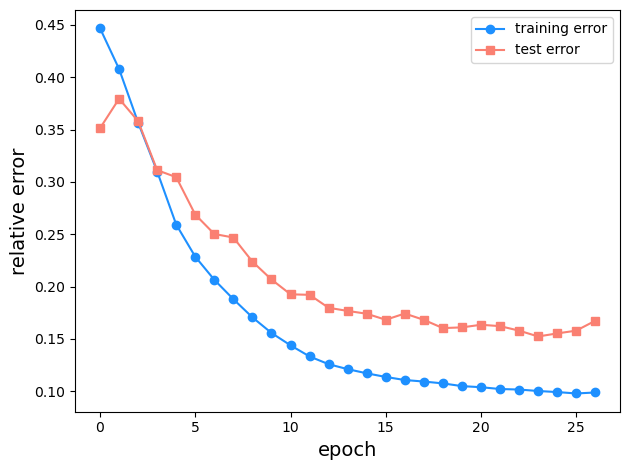

In [16]:
plot_errors(results_das)

### Get training results

In [17]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]
C_das = results_das['C_das'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. If the replica ensemble contains non-converged networks, this will show up as unreasonably large confidence intervals.

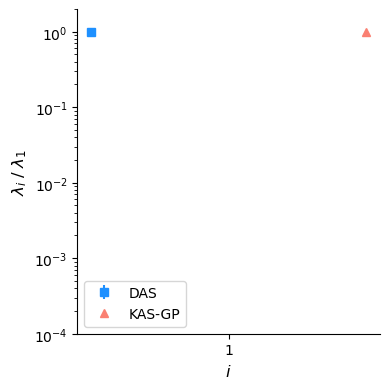

In [18]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# Load GP results from file
GP_eigvals = pd.read_csv('./GP_eigvals/scaled_eigen_results_epoxy_%s.csv' % (QoI,))
GP_mean = GP_eigvals['Eigenval_mean'].values
GP_std = GP_eigvals['Eigenval_std'].values

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
ax1.errorbar(np.arange(1, n_vals + 1)+offset, GP_mean[0:n_vals], 
             fmt='^', color='salmon', label='KAS-GP')#, yerr = GP_std[0:n_vals])
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/epoxy_eigvals_d%d.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [19]:
# run the surrogate at a number of random inputs locations drawn from U[-1, 1]
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])

In [20]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T
idx = np.argsort(y_val_das.flatten())

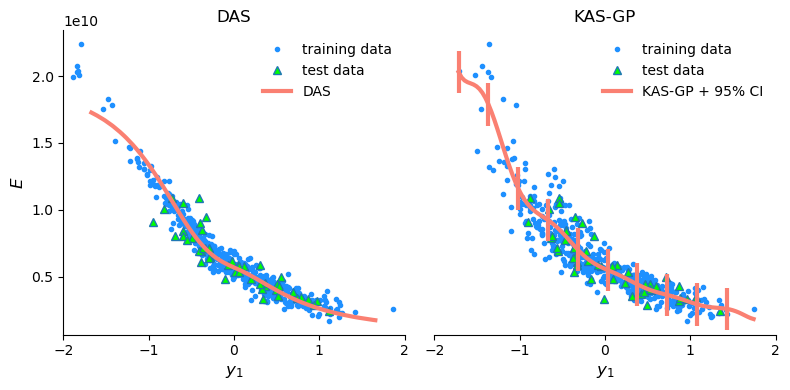

In [21]:
# QoI labels
lbl = {'E11': r'$E$', 'poisson': r'Poisson ratio'}

# plot DAS surrogate
fig = plt.figure(figsize=(8,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1])

ax = fig.add_subplot(spec[0],  xlim=[-2,2], title='DAS')   
#ax = fig.add_subpl2ot(111, ylim = [0.15, 0.45], xlim= [-2, 2]) # Poisson range
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(y_das_train[:,0], samples_train, '.', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', markerfacecolor='lime', label='test data') 
ax.plot(y_val_das[idx,0], das_samples_pred[idx], color='salmon', label='DAS', linewidth=3)
leg = ax.legend(loc=0, frameon=False)

ax2 = fig.add_subplot(spec[1], sharex = ax, ylim = ax.get_ylim(), title='KAS-GP') 
ax2.set_xlabel(r'$y_1$', fontsize=12)

# also plot GP surrogate from file
y_mean = das_surrogate.neural_net.y_mean
y_std = das_surrogate.neural_net.y_std
GP_surrogate = np.load('./GP_surrogate/epoxy_%s_results.npy' % (QoI,), allow_pickle=True).item()
ax2.plot(GP_surrogate['reduced_train_params'], samples_train, '.', color='dodgerblue', label='training data')
ax2.plot(GP_surrogate['reduced_test_params'], samples_test, '^', markerfacecolor='lime', label='test data')
ax2.plot(GP_surrogate['active_subspace'], GP_surrogate['prediction_mean'] * y_std + y_mean, color='salmon',
        label='KAS-GP + 95% CI', linewidth=3)
skip=10
ax2.errorbar(GP_surrogate['active_subspace'][0:-1:skip].flatten(), 
             GP_surrogate['prediction_mean'][0:-1:skip].flatten() * y_std + y_mean,
             yerr = GP_surrogate['prediction_CI'][0:-1:skip].flatten() * y_std, color='salmon',
             linewidth=0, elinewidth=3)
leg = ax2.legend(loc=0, frameon=False)

sns.despine(top=True, ax=ax)
sns.despine(top=True, ax=ax2)
sns.despine(left=True, ax=ax2)
ax2.set_yticks([])

plt.tight_layout()
plt.savefig('./images/epoxy_surrogate_d%d_%s.png' % (d, QoI, ))


### Recreate the global-derivative based sensitivity plots

In [22]:
GP_results = pd.read_csv('./GP_SA/sensitivity_indices_epoxy_%s.csv' % (QoI,))

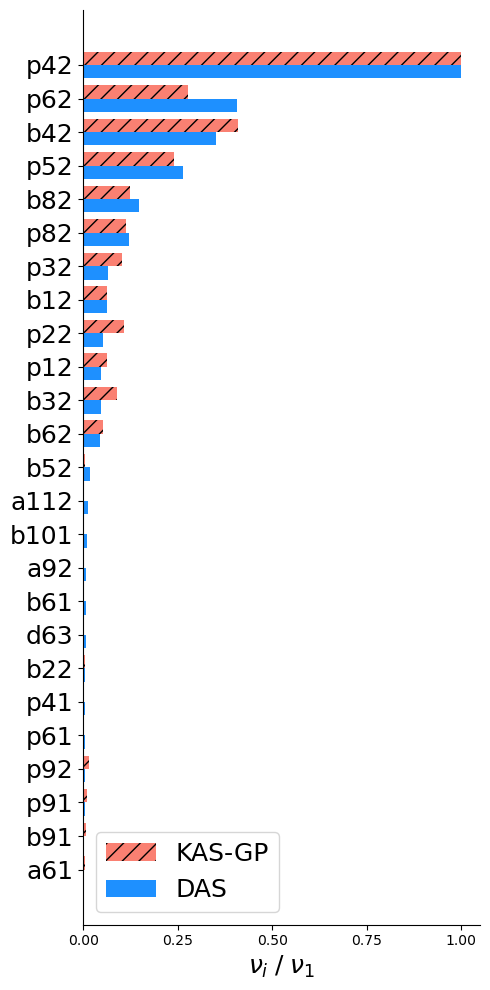

In [23]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names, bar2 = GP_results)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


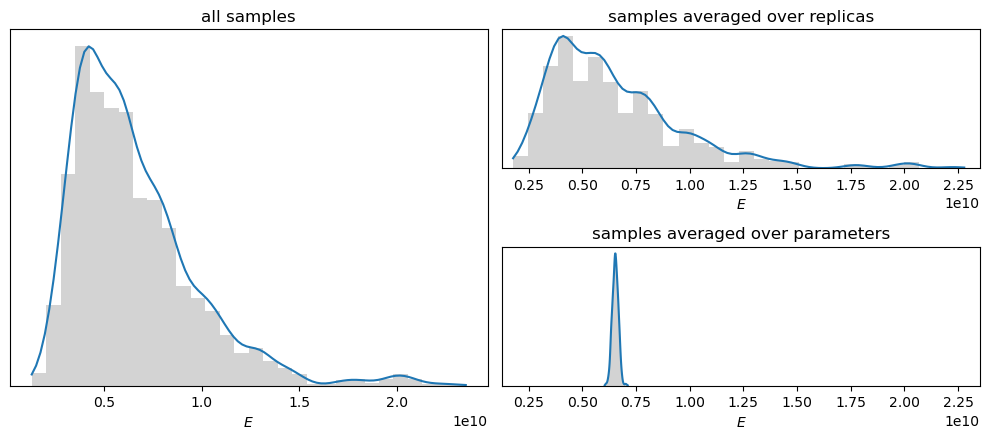

In [24]:
plot_dist(output, lbl[QoI])

### (Non-Gaussian) stats with bootstrapping

In [31]:
n_bootstap = 10 ** 5
n_samples = output.size

mean = np.zeros(n_bootstap)
std = np.zeros(n_bootstap)
skew = np.zeros(n_bootstap)
kurt = np.zeros(n_bootstap)

output = output.flatten() 

for i in tqdm(range(n_bootstap)):
    # resample with replacement
    idx = np.random.randint(0, n_samples, n_samples)
    # recompute moments
    mean[i] = np.mean(output[idx])
    std[i] = np.std(output[idx])
    skew[i] = stats.skew(output[idx])
    kurt[i] = stats.kurtosis(output[idx])

In [ ]:
lower_mean, upper_mean = analysis.get_confidence_intervals(mean.reshape([-1,1]))
lower_std, upper_std = analysis.get_confidence_intervals(std.reshape([-1,1]))
lower_skew, upper_skew = analysis.get_confidence_intervals(skew.reshape([-1,1]))
lower_kurt, upper_kurt = analysis.get_confidence_intervals(kurt.reshape([-1,1]))

In [ ]:
print("Mean: %.2e (%.2e/%.2e)" % (np.mean(output), lower_mean, upper_mean))
print("Std dev: %.2e (%.2e/%.2e)" % (np.std(output), lower_std, upper_std))
print("Skew: %.2f (%.3f/%.3f)" % (stats.skew(output), lower_skew, upper_skew))
print("Kurt: %.2f (%.2f/%.2f)" % (stats.kurtosis(output), lower_kurt, upper_kurt))
print("N_samples = %d" % n_samples)